# Visualising heatmaps of class activations

In [3]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [4]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [5]:
preds = model.predict(x)
print("Predicted:", decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.9094207), ('n01871265', 'tusker', 0.08618318), ('n02504013', 'Indian_elephant', 0.004354581)]


In [6]:
print("African elephant is class number:", np.argmax(preds))
print("Probability of african elephant:", preds[0, np.argmax(preds)])

African elephant is class number: 386
Probability of african elephant: 0.9094207


In [7]:
african_elephant_output = model.output[:, 386]  # shape: (?,)
last_conv_layer = model.get_layer("block5_conv3")
print('last_conv_layer.output.shape:', last_conv_layer.output.shape)

last_conv_layer.output.shape: (?, 14, 14, 512)


Now compute the gradients of the model output (the predicted class) with regards to the output feature map of the last convolutional layer.

In [8]:
import keras.backend as K

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
print('grads.shape:', grads.shape)

pooled_grads = K.mean(grads, axis=(0, 1, 2))
print('pooled_grads.shape:', pooled_grads.shape)

grads.shape: (?, 14, 14, 512)
pooled_grads.shape: (512,)


In [9]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)

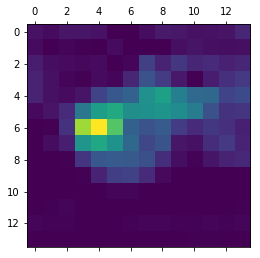

In [10]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [11]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

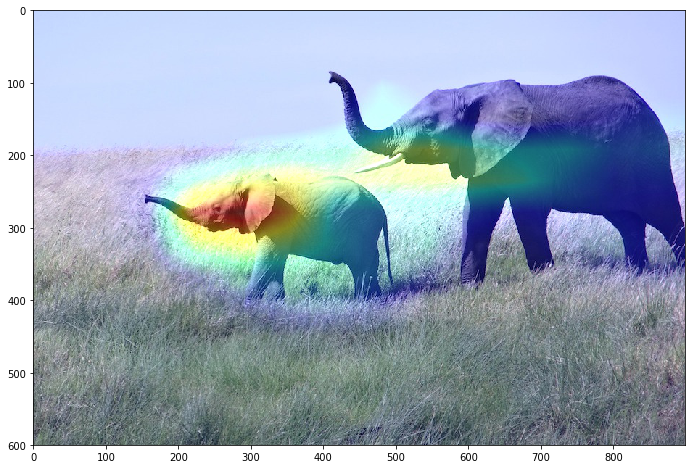

In [15]:
img_to_show = cv2.imread('elephant_cam.jpg')
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB))
plt.show()